<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [6]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

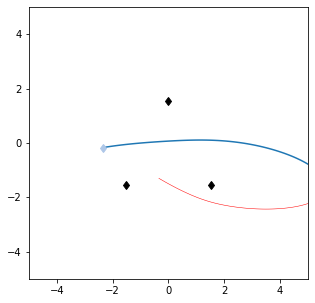

Charges are [-0.07307143 -0.30110073 -0.15867207]


In [7]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [19]:
# Pick the best device
import torch

def try_device(device):
    # Try to put an array on given device. If successful, return device. Else, 'cpu'.
    x = torch.ones((1,))
    try:
        x.to(device)
        return device
    except:
        return 'cpu'

device = try_device('cuda')
if device == 'cpu':
    # mps doesn't support our model (yet?)
    # device = try_device('mps')
    pass


print(f'Device is set to {device}')

Device is set to cuda


In [9]:
# Task 3.1: Using the positions of positively charged particle p1 during a simulation, predict the
# values of negative charges c2, c3, c4
# input = t locations (x, y) of p1 particle, value of t is not fixed

from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_sequence, pad_sequence

class SimulationData(Dataset):
    def __init__(self, sim, charges):
        self.sim = sim
        self.charges = charges

    def __len__(self):
        return len(self.sim)

    def __getitem__(self, idx):
        return self.sim[idx], self.charges[idx]

# Create data loader
def cpu_collate(data):
    # Sort data in order of decreasing sequence length
    data = list(reversed(sorted(data, key=lambda d: len(d[0]))))
    xs = pad_sequence([torch.tensor(x).float() for x, _ in data], batch_first=True)
    ys = torch.stack([torch.tensor(y).float() for _, y in data])
    return xs, ys


# Create data loader
def gpu_collate(data):
    # Sort data in order of decreasing sequence length
    data = list(reversed(sorted(data, key=lambda d: len(d[0]))))
    xs = pad_sequence([torch.tensor(x).float() for x, _ in data], batch_first=True)
    ys = torch.stack([torch.tensor(y).float() for _, y in data])
    return xs.to(device), ys.to(device)


# Batch size needs to evenly divide all train, valid, test sizes (800, 100, 100)
batch_size = 5
cpu_train_dl = DataLoader(SimulationData(simulation_train, charges_train), batch_size=batch_size, shuffle=True, collate_fn=cpu_collate)
cpu_valid_dl = DataLoader(SimulationData(simulation_valid, charges_valid), batch_size=batch_size, shuffle=True, collate_fn=cpu_collate)

gpu_train_dl = DataLoader(SimulationData(simulation_train, charges_train), batch_size=batch_size, shuffle=True, collate_fn=gpu_collate)
gpu_valid_dl = DataLoader(SimulationData(simulation_valid, charges_valid), batch_size=batch_size, shuffle=True, collate_fn=gpu_collate)


In [11]:
print(simulation_train[0].shape)
# Test data loader
xs, ys = next(iter(cpu_train_dl))
print(len(xs))
print(xs[0].shape, ys[0].shape)

(103, 2)
5
torch.Size([108, 2]) torch.Size([3])


In [12]:
# Baseline model: predict the mean value of each charge in the training set
baseline_values = torch.tensor(np.array(charges_train).mean(axis=0))
def baseline_predict(xs):
    batch = xs.shape[0]
    return baseline_values.expand(batch, 3)

loss_fn = lambda y, y_pred: (y - y_pred).abs().sum()

# Baseline error?

def avg_err(model, dl, loss_fn=torch.nn.L1Loss(reduction='sum')):
    loss = 0
    n_samples = 0
    for x, y in dl:
        y_pred = model(x)
        loss += loss_fn(y, y_pred)
        n_samples += x.shape[0]
    return loss / n_samples


print(f'Baseline L1 train error: {avg_err(baseline_predict, cpu_train_dl)}')
print(f'Baseline L1 validation error: {avg_err(baseline_predict, cpu_valid_dl)}')

Baseline L1 train error: 0.7429318428039551
Baseline L1 validation error: 0.7968491911888123


## Model Implementation

In [13]:
class Model_3_1(torch.nn.Module):
    def __init__(self, hidden_dim, n_layers, batch_size):
        super(Model_3_1, self).__init__()
        # input/output size are fixed based on the task description
        input_dim = 2
        output_dim = 3

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        self.gru = torch.nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True)
        self.relu = torch.nn.ReLU()
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = self.init_hidden()
        x = x.to(device)
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out
    
    def init_hidden(self):
        # from example of https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        h0 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim).to(device)
        return h0

xs = xs.to(device)
model_3_1 = Model_3_1(30, 5, batch_size).to(device)
print(model_3_1(xs).shape)

torch.Size([5, 3])


## Model Training

In [44]:
from tqdm import tqdm

train_loss_graph, val_loss_graph = list(), list()

def fit_3_1(model, train_dl, valid_dl, n_epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loss_func = torch.nn.L1Loss()
    loss_func = loss_func.to(device)

    for i in range(n_epochs):
        print(f'Begin epoch {i + 1}/{n_epochs}')
        for x, y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device).float()
            y_pred = model(x)
            loss = loss_func(y, y_pred)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        with torch.no_grad():
            train_err = avg_err(model, train_dl)
            val_err = avg_err(model, valid_dl)
            print(f'L1 train error: {train_err}')
            print(f'L1 validation error: {val_err}')
            train_loss_graph.append(train_err)
            val_loss_graph.append(val_err)

In [45]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

hidden_size = 30
n_layers = 5
model_3_1 = Model_3_1(hidden_size, n_layers, batch_size).to(device)
print(f'Model has {count_parameters(model_3_1)} parameters')
epochs = 150
fit_3_1(model_3_1, gpu_train_dl, gpu_valid_dl, epochs)

Model has 25473 parameters
Begin epoch 1/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.04it/s]


L1 train error: 0.7328307032585144
L1 validation error: 0.7619458436965942
Begin epoch 2/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.50it/s]


L1 train error: 0.6017531156539917
L1 validation error: 0.6357011198997498
Begin epoch 3/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.74it/s]


L1 train error: 0.6055735945701599
L1 validation error: 0.6395753622055054
Begin epoch 4/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.24it/s]


L1 train error: 0.504177451133728
L1 validation error: 0.5267606973648071
Begin epoch 5/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 68.38it/s]


L1 train error: 0.47816261649131775
L1 validation error: 0.4654507637023926
Begin epoch 6/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 68.95it/s]


L1 train error: 0.4323008954524994
L1 validation error: 0.4132891297340393
Begin epoch 7/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 68.20it/s]


L1 train error: 0.4464136064052582
L1 validation error: 0.48416075110435486
Begin epoch 8/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.12it/s]


L1 train error: 0.41048935055732727
L1 validation error: 0.4169163107872009
Begin epoch 9/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 65.48it/s]


L1 train error: 0.4110434651374817
L1 validation error: 0.4104712903499603
Begin epoch 10/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.75it/s]


L1 train error: 0.41151922941207886
L1 validation error: 0.4121166467666626
Begin epoch 11/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.95it/s]


L1 train error: 0.36165744066238403
L1 validation error: 0.36849963665008545
Begin epoch 12/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 68.38it/s]


L1 train error: 0.3612075448036194
L1 validation error: 0.3787432909011841
Begin epoch 13/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.39it/s]


L1 train error: 0.34647291898727417
L1 validation error: 0.36202529072761536
Begin epoch 14/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.81it/s]


L1 train error: 0.3359376788139343
L1 validation error: 0.35319700837135315
Begin epoch 15/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.13it/s]


L1 train error: 0.31537771224975586
L1 validation error: 0.3407256305217743
Begin epoch 16/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.33it/s]


L1 train error: 0.3062566816806793
L1 validation error: 0.32741647958755493
Begin epoch 17/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.83it/s]


L1 train error: 0.3078247904777527
L1 validation error: 0.31957000494003296
Begin epoch 18/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.74it/s]


L1 train error: 0.2982976734638214
L1 validation error: 0.30352580547332764
Begin epoch 19/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.80it/s]


L1 train error: 0.30141741037368774
L1 validation error: 0.3327621817588806
Begin epoch 20/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 68.15it/s]


L1 train error: 0.3184242248535156
L1 validation error: 0.3375991880893707
Begin epoch 21/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 68.53it/s]


L1 train error: 0.287388414144516
L1 validation error: 0.3182353377342224
Begin epoch 22/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.27it/s]


L1 train error: 0.27272912859916687
L1 validation error: 0.2964199185371399
Begin epoch 23/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.54it/s]


L1 train error: 0.26363006234169006
L1 validation error: 0.2774542570114136
Begin epoch 24/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.37it/s]


L1 train error: 0.2549857199192047
L1 validation error: 0.31210455298423767
Begin epoch 25/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.48it/s]


L1 train error: 0.2583114802837372
L1 validation error: 0.2994951605796814
Begin epoch 26/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.78it/s]


L1 train error: 0.24654345214366913
L1 validation error: 0.29262444376945496
Begin epoch 27/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.89it/s]


L1 train error: 0.2261524796485901
L1 validation error: 0.2321389764547348
Begin epoch 28/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.97it/s]


L1 train error: 0.245222270488739
L1 validation error: 0.2737250328063965
Begin epoch 29/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.82it/s]


L1 train error: 0.2256159782409668
L1 validation error: 0.25214365124702454
Begin epoch 30/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.43it/s]


L1 train error: 0.23021890223026276
L1 validation error: 0.27025583386421204
Begin epoch 31/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.80it/s]


L1 train error: 0.20757070183753967
L1 validation error: 0.23794881999492645
Begin epoch 32/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.55it/s]


L1 train error: 0.24898497760295868
L1 validation error: 0.2951958477497101
Begin epoch 33/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.63it/s]


L1 train error: 0.22061392664909363
L1 validation error: 0.25348803400993347
Begin epoch 34/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.14it/s]


L1 train error: 0.21035753190517426
L1 validation error: 0.23783168196678162
Begin epoch 35/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.70it/s]


L1 train error: 0.22819942235946655
L1 validation error: 0.2580842673778534
Begin epoch 36/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.34it/s]


L1 train error: 0.23184362053871155
L1 validation error: 0.27607250213623047
Begin epoch 37/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.82it/s]


L1 train error: 0.2044658362865448
L1 validation error: 0.23390574753284454
Begin epoch 38/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.15it/s]


L1 train error: 0.19403035938739777
L1 validation error: 0.22492694854736328
Begin epoch 39/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.66it/s]


L1 train error: 0.22096826136112213
L1 validation error: 0.25676852464675903
Begin epoch 40/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.14it/s]


L1 train error: 0.19072143733501434
L1 validation error: 0.22024430334568024
Begin epoch 41/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.71it/s]


L1 train error: 0.17769372463226318
L1 validation error: 0.2233038991689682
Begin epoch 42/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.51it/s]


L1 train error: 0.1896410882472992
L1 validation error: 0.21944640576839447
Begin epoch 43/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.59it/s]


L1 train error: 0.21500857174396515
L1 validation error: 0.23785999417304993
Begin epoch 44/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.73it/s]


L1 train error: 0.19552822411060333
L1 validation error: 0.21311844885349274
Begin epoch 45/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.64it/s]


L1 train error: 0.18649819493293762
L1 validation error: 0.2174585610628128
Begin epoch 46/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.81it/s]


L1 train error: 0.17324313521385193
L1 validation error: 0.2054947018623352
Begin epoch 47/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 78.26it/s]


L1 train error: 0.17614483833312988
L1 validation error: 0.22176235914230347
Begin epoch 48/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.95it/s]


L1 train error: 0.17964212596416473
L1 validation error: 0.20476658642292023
Begin epoch 49/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.62it/s]


L1 train error: 0.19048915803432465
L1 validation error: 0.24233466386795044
Begin epoch 50/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.70it/s]


L1 train error: 0.19148828089237213
L1 validation error: 0.2149127870798111
Begin epoch 51/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.02it/s]


L1 train error: 0.19412057101726532
L1 validation error: 0.22145164012908936
Begin epoch 52/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.92it/s]


L1 train error: 0.1654762476682663
L1 validation error: 0.19611960649490356
Begin epoch 53/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.42it/s]


L1 train error: 0.1756943315267563
L1 validation error: 0.220437154173851
Begin epoch 54/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.72it/s]


L1 train error: 0.17688345909118652
L1 validation error: 0.20684222877025604
Begin epoch 55/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.54it/s]


L1 train error: 0.17253759503364563
L1 validation error: 0.2024705857038498
Begin epoch 56/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.01it/s]


L1 train error: 0.17965058982372284
L1 validation error: 0.2179626226425171
Begin epoch 57/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.38it/s]


L1 train error: 0.16360360383987427
L1 validation error: 0.19997413456439972
Begin epoch 58/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.89it/s]


L1 train error: 0.1584576517343521
L1 validation error: 0.19855035841464996
Begin epoch 59/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.58it/s]


L1 train error: 0.1955864131450653
L1 validation error: 0.22748669981956482
Begin epoch 60/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.80it/s]


L1 train error: 0.16693232953548431
L1 validation error: 0.21051615476608276
Begin epoch 61/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.10it/s]


L1 train error: 0.18895956873893738
L1 validation error: 0.21109206974506378
Begin epoch 62/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.30it/s]


L1 train error: 0.16283313930034637
L1 validation error: 0.19898448884487152
Begin epoch 63/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.08it/s]


L1 train error: 0.15065805613994598
L1 validation error: 0.18939617276191711
Begin epoch 64/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.86it/s]


L1 train error: 0.16683059930801392
L1 validation error: 0.2102113515138626
Begin epoch 65/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.43it/s]


L1 train error: 0.1563086062669754
L1 validation error: 0.19352534413337708
Begin epoch 66/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.36it/s]


L1 train error: 0.15219420194625854
L1 validation error: 0.1894087791442871
Begin epoch 67/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.99it/s]


L1 train error: 0.17565256357192993
L1 validation error: 0.21222442388534546
Begin epoch 68/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.41it/s]


L1 train error: 0.17106766998767853
L1 validation error: 0.21067723631858826
Begin epoch 69/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.99it/s]


L1 train error: 0.16834519803524017
L1 validation error: 0.22636961936950684
Begin epoch 70/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.69it/s]


L1 train error: 0.16210317611694336
L1 validation error: 0.19697226583957672
Begin epoch 71/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.73it/s]


L1 train error: 0.15341860055923462
L1 validation error: 0.19370877742767334
Begin epoch 72/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.25it/s]


L1 train error: 0.18824639916419983
L1 validation error: 0.22405177354812622
Begin epoch 73/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.37it/s]


L1 train error: 0.1524973213672638
L1 validation error: 0.19539976119995117
Begin epoch 74/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.66it/s]


L1 train error: 0.15645301342010498
L1 validation error: 0.18572314083576202
Begin epoch 75/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.63it/s]


L1 train error: 0.14256049692630768
L1 validation error: 0.19179317355155945
Begin epoch 76/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.40it/s]


L1 train error: 0.17792142927646637
L1 validation error: 0.21395736932754517
Begin epoch 77/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.12it/s]


L1 train error: 0.1508200466632843
L1 validation error: 0.209770068526268
Begin epoch 78/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.97it/s]


L1 train error: 0.16921140253543854
L1 validation error: 0.22804908454418182
Begin epoch 79/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.18it/s]


L1 train error: 0.16901181638240814
L1 validation error: 0.21424277126789093
Begin epoch 80/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.72it/s]


L1 train error: 0.14479465782642365
L1 validation error: 0.17775321006774902
Begin epoch 81/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.74it/s]


L1 train error: 0.14363974332809448
L1 validation error: 0.19535762071609497
Begin epoch 82/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.62it/s]


L1 train error: 0.14455553889274597
L1 validation error: 0.1767507940530777
Begin epoch 83/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.13it/s]


L1 train error: 0.1565140187740326
L1 validation error: 0.21114394068717957
Begin epoch 84/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.63it/s]


L1 train error: 0.1673271507024765
L1 validation error: 0.20210568606853485
Begin epoch 85/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:01<00:00, 80.81it/s]


L1 train error: 0.1423092931509018
L1 validation error: 0.1882171779870987
Begin epoch 86/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.84it/s]


L1 train error: 0.16799110174179077
L1 validation error: 0.21925701200962067
Begin epoch 87/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 79.40it/s]


L1 train error: 0.14455580711364746
L1 validation error: 0.17787785828113556
Begin epoch 88/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.73it/s]


L1 train error: 0.14718040823936462
L1 validation error: 0.20529966056346893
Begin epoch 89/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 78.69it/s]


L1 train error: 0.15881402790546417
L1 validation error: 0.19986006617546082
Begin epoch 90/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.11it/s]


L1 train error: 0.15914110839366913
L1 validation error: 0.2132977992296219
Begin epoch 91/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.51it/s]


L1 train error: 0.13453780114650726
L1 validation error: 0.1826593577861786
Begin epoch 92/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.96it/s]


L1 train error: 0.13858580589294434
L1 validation error: 0.19964717328548431
Begin epoch 93/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.27it/s]


L1 train error: 0.16504335403442383
L1 validation error: 0.21858619153499603
Begin epoch 94/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.97it/s]


L1 train error: 0.15114794671535492
L1 validation error: 0.1994553655385971
Begin epoch 95/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.01it/s]


L1 train error: 0.1361074298620224
L1 validation error: 0.1959923654794693
Begin epoch 96/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 79.00it/s]


L1 train error: 0.1588778793811798
L1 validation error: 0.2194259911775589
Begin epoch 97/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.30it/s]


L1 train error: 0.1563248634338379
L1 validation error: 0.19435201585292816
Begin epoch 98/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 78.69it/s]


L1 train error: 0.1420973390340805
L1 validation error: 0.19663098454475403
Begin epoch 99/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.75it/s]


L1 train error: 0.14775915443897247
L1 validation error: 0.18539054691791534
Begin epoch 100/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.25it/s]


L1 train error: 0.13826291263103485
L1 validation error: 0.18605157732963562
Begin epoch 101/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.65it/s]


L1 train error: 0.13475723564624786
L1 validation error: 0.1781642735004425
Begin epoch 102/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.68it/s]


L1 train error: 0.13888558745384216
L1 validation error: 0.21431255340576172
Begin epoch 103/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.75it/s]


L1 train error: 0.13840198516845703
L1 validation error: 0.19585536420345306
Begin epoch 104/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.33it/s]


L1 train error: 0.14465171098709106
L1 validation error: 0.17959679663181305
Begin epoch 105/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.99it/s]


L1 train error: 0.14859893918037415
L1 validation error: 0.19870392978191376
Begin epoch 106/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 78.58it/s]


L1 train error: 0.12393298000097275
L1 validation error: 0.17518284916877747
Begin epoch 107/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 69.81it/s]


L1 train error: 0.12178479135036469
L1 validation error: 0.1763008087873459
Begin epoch 108/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.93it/s]


L1 train error: 0.13600052893161774
L1 validation error: 0.1888454705476761
Begin epoch 109/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 69.88it/s]


L1 train error: 0.14925894141197205
L1 validation error: 0.19808731973171234
Begin epoch 110/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.23it/s]


L1 train error: 0.13498908281326294
L1 validation error: 0.17798858880996704
Begin epoch 111/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.96it/s]


L1 train error: 0.14077970385551453
L1 validation error: 0.20056869089603424
Begin epoch 112/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.58it/s]


L1 train error: 0.154440775513649
L1 validation error: 0.1846729964017868
Begin epoch 113/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.53it/s]


L1 train error: 0.15990006923675537
L1 validation error: 0.1883406788110733
Begin epoch 114/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.79it/s]


L1 train error: 0.11858536303043365
L1 validation error: 0.16480153799057007
Begin epoch 115/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.82it/s]


L1 train error: 0.12768009305000305
L1 validation error: 0.1723688542842865
Begin epoch 116/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.86it/s]


L1 train error: 0.14032988250255585
L1 validation error: 0.18389135599136353
Begin epoch 117/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 69.48it/s]


L1 train error: 0.14030085504055023
L1 validation error: 0.20434308052062988
Begin epoch 118/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.86it/s]


L1 train error: 0.1305730938911438
L1 validation error: 0.16936589777469635
Begin epoch 119/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.16it/s]


L1 train error: 0.13519547879695892
L1 validation error: 0.19068986177444458
Begin epoch 120/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.75it/s]


L1 train error: 0.14041411876678467
L1 validation error: 0.1747642308473587
Begin epoch 121/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.04it/s]


L1 train error: 0.11974682658910751
L1 validation error: 0.1683385968208313
Begin epoch 122/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.24it/s]


L1 train error: 0.1196492463350296
L1 validation error: 0.18100827932357788
Begin epoch 123/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.21it/s]


L1 train error: 0.12868469953536987
L1 validation error: 0.18373756110668182
Begin epoch 124/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.83it/s]


L1 train error: 0.1323874145746231
L1 validation error: 0.17905694246292114
Begin epoch 125/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.46it/s]


L1 train error: 0.14858749508857727
L1 validation error: 0.18687684834003448
Begin epoch 126/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.53it/s]


L1 train error: 0.13187859952449799
L1 validation error: 0.15834815800189972
Begin epoch 127/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.60it/s]


L1 train error: 0.12534041702747345
L1 validation error: 0.16600868105888367
Begin epoch 128/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 79.45it/s]


L1 train error: 0.12092798948287964
L1 validation error: 0.17095902562141418
Begin epoch 129/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.10it/s]


L1 train error: 0.12784314155578613
L1 validation error: 0.18386705219745636
Begin epoch 130/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.86it/s]


L1 train error: 0.1227097287774086
L1 validation error: 0.17665500938892365
Begin epoch 131/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.10it/s]


L1 train error: 0.12545594573020935
L1 validation error: 0.17803853750228882
Begin epoch 132/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.05it/s]


L1 train error: 0.1282404661178589
L1 validation error: 0.1746329963207245
Begin epoch 133/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.46it/s]


L1 train error: 0.1599554717540741
L1 validation error: 0.2242034524679184
Begin epoch 134/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.28it/s]


L1 train error: 0.11849996447563171
L1 validation error: 0.17623208463191986
Begin epoch 135/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.47it/s]


L1 train error: 0.12893901765346527
L1 validation error: 0.18107277154922485
Begin epoch 136/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 69.34it/s]


L1 train error: 0.12947356700897217
L1 validation error: 0.18397483229637146
Begin epoch 137/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.56it/s]


L1 train error: 0.12415756285190582
L1 validation error: 0.17599228024482727
Begin epoch 138/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.69it/s]


L1 train error: 0.1268746554851532
L1 validation error: 0.1634112447500229
Begin epoch 139/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.61it/s]


L1 train error: 0.1272561103105545
L1 validation error: 0.16599705815315247
Begin epoch 140/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.55it/s]


L1 train error: 0.1298612654209137
L1 validation error: 0.17108257114887238
Begin epoch 141/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.31it/s]


L1 train error: 0.15645714104175568
L1 validation error: 0.1908418834209442
Begin epoch 142/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.79it/s]


L1 train error: 0.11802775412797928
L1 validation error: 0.1704573929309845
Begin epoch 143/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.51it/s]


L1 train error: 0.15297000110149384
L1 validation error: 0.20487664639949799
Begin epoch 144/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.99it/s]


L1 train error: 0.1299508810043335
L1 validation error: 0.19016893208026886
Begin epoch 145/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.31it/s]


L1 train error: 0.12087375670671463
L1 validation error: 0.1931886225938797
Begin epoch 146/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.04it/s]


L1 train error: 0.12399359792470932
L1 validation error: 0.17883051931858063
Begin epoch 147/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 79.23it/s]


L1 train error: 0.14534366130828857
L1 validation error: 0.19175511598587036
Begin epoch 148/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.69it/s]


L1 train error: 0.12324099987745285
L1 validation error: 0.1842464655637741
Begin epoch 149/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.03it/s]


L1 train error: 0.13147832453250885
L1 validation error: 0.17707838118076324
Begin epoch 150/150


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.90it/s]


L1 train error: 0.12753254175186157
L1 validation error: 0.16482806205749512


Text(0, 0.5, 'loss value')

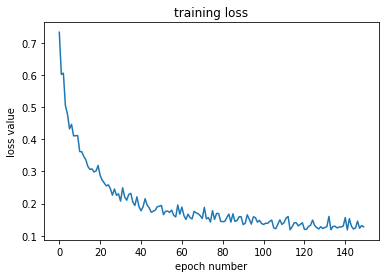

In [46]:
import matplotlib.pyplot as plt

train_loss_graph_cpu = [i.to(device='cpu') for i in train_loss_graph]

plt.plot(train_loss_graph_cpu)
plt.title("training loss")
plt.xlabel("epoch number")
plt.ylabel("loss value")

Text(0, 0.5, 'loss value')

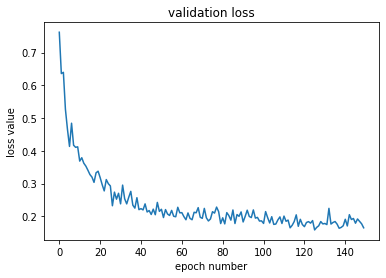

In [47]:
val_loss_graph_cpu = [i.to(device='cpu') for i in val_loss_graph]

plt.plot(val_loss_graph_cpu)
plt.title("validation loss")
plt.xlabel("epoch number")
plt.ylabel("loss value")

## Evaluation

In [15]:
#todo

# Task 3.2

## Data Handling and Preprocessing

In [16]:
#todo

## Model Implementation

In [16]:
x_train_shapes = [np.array(simulation_train_task32, dtype=object)[i].shape[0] for i in range(len(simulation_train_task32))]
y_train_shapes = [np.array(simulation_continued_train, dtype=object)[i].shape[0] for i in range(len(simulation_continued_train))]

In [18]:
print(f"Training x | Mean: {np.array(x_train_shapes).mean()}, Std: {np.array(x_train_shapes).std()}, Min: {np.array(x_train_shapes).min()}, Max: {np.array(x_train_shapes).max()}")
print(f"Training y | Mean: {np.array(y_train_shapes).mean()}, Std: {np.array(y_train_shapes).std()}, Min: {np.array(y_train_shapes).min()}, Max: {np.array(y_train_shapes).max()}")

Training x | Mean: 99.49333333333334, Std: 6.2841034010871875, Min: 90, Max: 110
Training y | Mean: 41.026666666666664, Std: 12.265913020326789, Min: 20, Max: 60


In [458]:
# Task 3.2: Using the positions of positively charged particle p1 during a simulation up to t=10 +- 1,
# continue its trajectory for an additional 4 +- 2 seconds.
# input = t locations (x, y) of p1 particle, value of t is not fixed
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_sequence, pad_sequence


global zero_x
zero_x = torch.zeros((110, 2))
global zero_y
zero_y = torch.zeros((60, 2))


class loadContinued(Dataset):
    def __init__(self, sim, cont_positions):
        self.sim = sim
        self.cont_positions = cont_positions
    
    def __len__(self):
        return len(self.sim)
    
    def __getitem__(self, index):
        return self.sim[index], self.cont_positions[index]

# Create data loader
def gpu_collate(data):
    # Sort data in order of decreasing sequence length
    data = list(reversed(sorted(data, key=lambda d: len(d[0]))))
    
    data_x = [torch.tensor(x).float() for x, _ in data][0]
    xs = pad_sequence([data_x, zero_x])
    xs = xs[:,0,:]
    
    ys = pad_sequence([[torch.tensor(y).float() for _, y in data][0], zero_y])
    ys = ys[:, 0, :]
    
    xs = torch.unsqueeze(xs, 1)
    ys = torch.unsqueeze(ys, 1)
    
    return xs.to(device), ys.to(device)


# No batch size since the length of y differs for each simulation.
gpu_cont_train_dl = DataLoader(loadContinued(simulation_train_task32, simulation_continued_train), shuffle=True, collate_fn=gpu_collate)
gpu_cont_valid_dl = DataLoader(loadContinued(simulation_valid, simulation_continued_valid), shuffle=True, collate_fn=gpu_collate)


In [459]:
from torch import nn

In [473]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, dropout):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.n_layers = n_layers
        
        self.gru = torch.nn.GRU(input_size, hidden_size, n_layers)
        
    def forward(self, x):
        hidden = self.init_hidden()
        output, hidden = self.gru(x, hidden)
        
        return output, hidden
    
    def init_hidden(self):
        h0 = torch.randn(self.n_layers, self.hidden_size).to(device)
        return h0
        

In [474]:
class Decoder(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers, dropout):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_size, hidden_size, n_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x, hidden):
        output, hidden = self.gru(x, hidden)
        output = self.out(output)
        output = self.relu(output)
        
        return output, hidden
    

In [475]:
from tqdm import tqdm
import random

train_loss_graph, val_loss_graph = list(), list()
criterion = torch.nn.L1Loss()


def fit_seq(encoder_model, decoder_model, train_dl, valid_dl, n_epochs, teacher_forcing_ratio):
    lr = 1e-4
    encoder_optimizer = torch.optim.AdamW(encoder_model.parameters(), lr=lr)
    decoder_optimizer = torch.optim.AdamW(decoder_model.parameters(), lr=lr)
    loss_func = torch.nn.L1Loss()
    loss_func = loss_func.to(device)

    for i in range(epochs):
        print(f'Begin epoch {i + 1}/{n_epochs}')
        train_loss, val_loss = list(), list()
        
        encoder_model = encoder_model.train()
        decoder_model = decoder_model.train()
        for x, y in tqdm(train_dl):
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            
            encoder_output, hidden = encoder_model(x.squeeze(1))
            outputs = torch.zeros(y.shape[0], 2).to(device)
            
            input_decoder = y[0][0]
            input_decoder = input_decoder.unsqueeze(0)
            for inx, y_i in enumerate(y):
                output, hidden = decoder_model(input_decoder, hidden)
                
                outputs[inx] = output
                
                teacher_force = random.random() < teacher_forcing_ratio
                input_decoder = y_i if teacher_force else output
            
            y = y.squeeze(1)
            loss = loss_func(outputs, y)
            loss.backward()
            
            encoder_optimizer.step()
            decoder_optimizer.step()
            
            train_loss.append(loss.item())            
            torch.cuda.empty_cache()
        
        train_loss_graph.append(sum(train_loss) / len(train_dl))
        
        encoder_model = encoder_model.eval()
        decoder_model = decoder_model.eval()
        for x_val, y_val in valid_dl:
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            
            encoder_output, hidden = encoder_model(x_val.squeeze(1))
            outputs_val = torch.zeros(y_val.shape[0], 2).to(device)
            
            input_decoder = y_val[0][0]
            input_decoder = input_decoder.unsqueeze(0)
            for inx, y_i in enumerate(y_val):
                output, hidden = decoder_model(input_decoder, hidden)
                
                outputs_val[inx] = output
                
                teacher_force = random.random() < teacher_forcing_ratio
                input_decoder = y_i if teacher_force else output
            
            y_val = y_val.squeeze(1)
            loss_val = loss_func(outputs_val, y_val)
            
            val_loss.append(loss_val.item())
            torch.cuda.empty_cache()
            
        val_loss_graph.append(sum(val_loss) / len(valid_dl))
        
        print(f'Average loss: {round(train_loss_graph[-1],5)}')
        print(f'val loss: {round(val_loss_graph[-1],5)}\n')
    


In [476]:
n_layers = 5
dropout = 0.5
input_size = 2
output_size = 2
hidden_size = 128

encoder_model = Encoder(input_size, hidden_size, n_layers, dropout).to(device)
decoder_model = Decoder(input_size, output_size, hidden_size, n_layers, dropout).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Encoder Model has {count_parameters(encoder_model)} parameters')
print(f'Decoder Model has {count_parameters(decoder_model)} parameters')
epochs = 50
fit_seq(encoder_model=encoder_model,
        decoder_model=decoder_model,
        train_dl=gpu_cont_train_dl, 
        valid_dl=gpu_cont_valid_dl, 
        n_epochs=epochs, 
        teacher_forcing_ratio=0.5)

Encoder Model has 446976 parameters
Decoder Model has 447234 parameters
Begin epoch 1/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:22<00:00,  6.56it/s]


Average loss: 0.98217
val loss: 0.94864

Begin epoch 2/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:24<00:00,  6.14it/s]


Average loss: 0.90006
val loss: 0.88557

Begin epoch 3/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:23<00:00,  6.40it/s]


Average loss: 0.84997
val loss: 0.82066

Begin epoch 4/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:24<00:00,  6.09it/s]


Average loss: 0.81614
val loss: 0.84212

Begin epoch 5/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:24<00:00,  6.18it/s]


Average loss: 0.78822
val loss: 0.80664

Begin epoch 6/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:26<00:00,  5.68it/s]


Average loss: 0.77563
val loss: 0.79324

Begin epoch 7/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:31<00:00,  4.80it/s]


Average loss: 0.75922
val loss: 0.77317

Begin epoch 8/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:31<00:00,  4.71it/s]


Average loss: 0.74199
val loss: 0.74855

Begin epoch 9/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:29<00:00,  5.09it/s]


Average loss: 0.72581
val loss: 0.73129

Begin epoch 10/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:28<00:00,  5.29it/s]


Average loss: 0.72017
val loss: 0.72988

Begin epoch 11/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:28<00:00,  5.23it/s]


Average loss: 0.69835
val loss: 0.72827

Begin epoch 12/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:31<00:00,  4.78it/s]


Average loss: 0.69144
val loss: 0.68666

Begin epoch 13/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:28<00:00,  5.35it/s]


Average loss: 0.68365
val loss: 0.68771

Begin epoch 14/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:29<00:00,  5.06it/s]


Average loss: 0.6725
val loss: 0.66898

Begin epoch 15/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:35<00:00,  4.28it/s]


Average loss: 0.65812
val loss: 0.66922

Begin epoch 16/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:31<00:00,  4.84it/s]


Average loss: 0.6635
val loss: 0.68461

Begin epoch 17/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:35<00:00,  4.22it/s]


Average loss: 0.65436
val loss: 0.66126

Begin epoch 18/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:23<00:00,  6.31it/s]


Average loss: 0.6554
val loss: 0.72518

Begin epoch 19/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:18<00:00,  8.27it/s]


Average loss: 0.65403
val loss: 0.66793

Begin epoch 20/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:23<00:00,  6.50it/s]


Average loss: 0.65744
val loss: 0.68324

Begin epoch 21/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:34<00:00,  4.38it/s]


Average loss: 0.6485
val loss: 0.65306

Begin epoch 22/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:34<00:00,  4.37it/s]


Average loss: 0.6419
val loss: 0.65714

Begin epoch 23/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:34<00:00,  4.39it/s]


Average loss: 0.64477
val loss: 0.66383

Begin epoch 24/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:32<00:00,  4.56it/s]


Average loss: 0.65329
val loss: 0.7007

Begin epoch 25/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:31<00:00,  4.70it/s]


Average loss: 0.6432
val loss: 0.6561

Begin epoch 26/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:31<00:00,  4.69it/s]


Average loss: 0.63848
val loss: 0.65217

Begin epoch 27/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:33<00:00,  4.51it/s]


Average loss: 0.63734
val loss: 0.66698

Begin epoch 28/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:36<00:00,  4.12it/s]


Average loss: 0.64961
val loss: 0.64838

Begin epoch 29/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:24<00:00,  6.25it/s]


Average loss: 0.63544
val loss: 0.64599

Begin epoch 30/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:31<00:00,  4.82it/s]


Average loss: 0.63965
val loss: 0.66058

Begin epoch 31/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:28<00:00,  5.22it/s]


Average loss: 0.63912
val loss: 0.64567

Begin epoch 32/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:30<00:00,  4.92it/s]


Average loss: 0.64617
val loss: 0.64078

Begin epoch 33/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:28<00:00,  5.35it/s]


Average loss: 0.63381
val loss: 0.6436

Begin epoch 34/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:25<00:00,  5.82it/s]


Average loss: 0.63554
val loss: 0.65072

Begin epoch 35/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:26<00:00,  5.59it/s]


Average loss: 0.62943
val loss: 0.63918

Begin epoch 36/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:28<00:00,  5.26it/s]


Average loss: 0.64092
val loss: 0.63771

Begin epoch 37/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:25<00:00,  5.78it/s]


Average loss: 0.63888
val loss: 0.63398

Begin epoch 38/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:29<00:00,  5.16it/s]


Average loss: 0.63889
val loss: 0.63763

Begin epoch 39/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.24it/s]


Average loss: 0.63524
val loss: 0.6434

Begin epoch 40/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:17<00:00,  8.51it/s]


Average loss: 0.63159
val loss: 0.64285

Begin epoch 41/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:19<00:00,  7.87it/s]


Average loss: 0.6334
val loss: 0.63981

Begin epoch 42/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:17<00:00,  8.70it/s]


Average loss: 0.6316
val loss: 0.66195

Begin epoch 43/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:16<00:00,  8.96it/s]


Average loss: 0.63941
val loss: 0.64477

Begin epoch 44/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:17<00:00,  8.80it/s]


Average loss: 0.63891
val loss: 0.64679

Begin epoch 45/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:16<00:00,  9.00it/s]


Average loss: 0.63917
val loss: 0.65126

Begin epoch 46/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:16<00:00,  9.27it/s]


Average loss: 0.63518
val loss: 0.64372

Begin epoch 47/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:16<00:00,  9.36it/s]


Average loss: 0.6353
val loss: 0.65762

Begin epoch 48/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:15<00:00,  9.38it/s]


Average loss: 0.62895
val loss: 0.64156

Begin epoch 49/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:16<00:00,  9.34it/s]


Average loss: 0.63668
val loss: 0.64396

Begin epoch 50/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:15<00:00,  9.41it/s]


Average loss: 0.62925
val loss: 0.65072



In [493]:
print(outputs)

tensor([[5.6717e-01, 7.7868e-01],
        [3.6124e-01, 9.8075e-01],
        [2.3740e-01, 1.1477e+00],
        [1.6383e-01, 1.3455e+00],
        [1.4172e-01, 1.5622e+00],
        [1.6731e-01, 1.7908e+00],
        [2.3488e-01, 2.0217e+00],
        [3.3856e-01, 2.2428e+00],
        [4.7311e-01, 2.4401e+00],
        [6.3475e-01, 2.6003e+00],
        [8.2029e-01, 2.7147e+00],
        [1.0268e+00, 2.7793e+00],
        [1.2516e+00, 2.7957e+00],
        [1.4902e+00, 2.7672e+00],
        [1.7362e+00, 2.6986e+00],
        [1.9814e+00, 2.5965e+00],
        [2.2162e+00, 2.4675e+00],
        [2.4319e+00, 2.3198e+00],
        [2.6211e+00, 2.1617e+00],
        [2.7814e+00, 2.0008e+00],
        [2.9135e+00, 1.8427e+00],
        [3.0199e+00, 1.6917e+00],
        [3.1049e+00, 1.5499e+00],
        [3.1723e+00, 1.4181e+00],
        [3.2253e+00, 1.2966e+00],
        [3.2664e+00, 1.1852e+00],
        [3.2977e+00, 1.0835e+00],
        [3.3208e+00, 9.9079e-01],
        [3.3372e+00, 9.0617e-01],
        [3.348

torch.Size([110, 1, 2]) torch.Size([60, 1, 2])


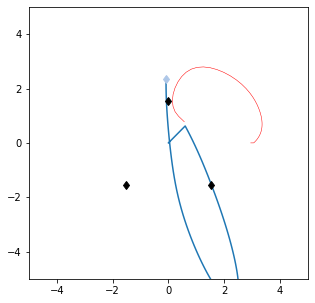

In [491]:
x, y = next(iter(gpu_cont_train_dl))

print(x.shape, y.shape)

encoder_output, hidden = encoder_model(x.squeeze(1))
outputs = torch.zeros(y.shape[0], 2).to(device)

input_decoder = y[0][0]
input_decoder = input_decoder.unsqueeze(0)
for inx, y_i in enumerate(y):
    output, hidden = decoder_model(input_decoder, hidden)

    outputs[inx] = output

    input_decoder = output

x = x.squeeze(1)
x = x.to(device='cpu').detach().numpy()
new_y_pred = outputs.to(device='cpu').detach().numpy()
    
plot_example(x, np.array(new_y_pred))

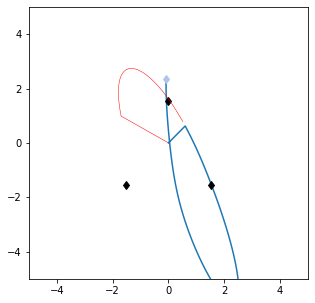

In [492]:
y = y.squeeze(1)
y = y.to(device='cpu').detach().numpy()
plot_example(x, y)

In [65]:
# Task 3.2: Using the positions of positively charged particle p1 during a simulation up to t=10 +- 1,
# continue its trajectory for an additional 4 +- 2 seconds.
# input = t locations (x, y) of p1 particle, value of t is not fixed
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_sequence, pad_sequence

class loadContinued(Dataset):
    def __init__(self, sim, cont_positions):
        self.sim = sim
        self.cont_positions = cont_positions
    
    def __len__(self):
        return len(self.sim)
    
    def __getitem__(self, index):
        return self.sim[index], self.cont_positions[index]

# Create data loader
def cpu_collate(data):
    
    # Sort data in order of decreasing sequence length
    data = list(reversed(sorted(data, key=lambda d: len(d[0]))))
    xs = pad_sequence([torch.tensor(x).float() for x, _ in data], batch_first=True)
    ys = torch.stack([torch.tensor(y).float() for _, y in data])
    return xs, ys


# Create data loader
def gpu_collate(data):
    # Sort data in order of decreasing sequence length
    data = list(reversed(sorted(data, key=lambda d: len(d[0]))))
    xs = pad_sequence([torch.tensor(x).float() for x, _ in data], batch_first=True)
    ys = torch.stack([torch.tensor(y).float() for _, y in data])
    return xs.to(device), ys.to(device)


# No batch size since the length of y differs for each simulation.
cpu_cont_train_dl = DataLoader(loadContinued(simulation_train_task32, simulation_continued_train), shuffle=True, collate_fn=cpu_collate)
cpu_cont_valid_dl = DataLoader(loadContinued(simulation_valid, simulation_continued_valid), shuffle=True, collate_fn=cpu_collate)

gpu_cont_train_dl = DataLoader(loadContinued(simulation_train_task32, simulation_continued_train), shuffle=True, collate_fn=gpu_collate)
gpu_cont_valid_dl = DataLoader(loadContinued(simulation_valid, simulation_continued_valid), shuffle=True, collate_fn=gpu_collate)


In [173]:
class Model_3_2(torch.nn.Module):
    def __init__(self, hidden_dim, n_layers, batch_size):
        super(Model_3_2, self).__init__()
        # input/output size are fixed based on the task description
        input_dim = 2
        output_dim = 2

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        self.gru = torch.nn.GRU(input_dim, hidden_dim, n_layers)
        self.relu = torch.nn.ReLU()
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, inx):
        h = self.init_hidden(x)
        x = x.to(device)
        out, h = self.gru(torch.mul(x, (inx+1)/100), h)
        out = torch.mul(out,1+(inx+1)/100)
        out = self.fc(self.relu(out[:,-1]))
        return out
    
    def init_hidden(self, x):
        # from example of https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        h0 = torch.randn(self.n_layers, x.shape[1], self.hidden_dim).to(device)
        return h0

xs = xs.to(device)
model_3_2 = Model_3_2(30, 1, 1).to(device)
print(model_3_2(xs, 1).shape)

torch.Size([5, 2])


In [238]:
class Model_3_22(torch.nn.Module):
    def __init__(self, hidden_dim, n_layers, batch_size):
        super(Model_3_22, self).__init__()
        # input/output size are fixed based on the task description
        input_dim = 2
        self.output_dim = 2

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        self.gru0 = torch.nn.GRU(input_dim, hidden_dim, n_layers)
        self.gru1 = torch.nn.GRU(hidden_dim, hidden_dim, n_layers)
        self.gru2 = torch.nn.GRU(hidden_dim, hidden_dim, n_layers)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x, no_to_predict):
        h = self.init_hidden(x)
        x = x.to(device)
        out0, h1 = self.gru0(x, h[0])
        out1, h2 = self.gru1(out0, h[1])
        out2, h3 = self.gru2(out1, h[2])
        
        out = self.relu(out2[:,-1])
        out = torch.nn.Linear(self.hidden_dim, self.output_dim*no_to_predict).to(device)(out)
        out = out.view((no_to_predict, 2))
        return out
    
    def init_hidden(self, x):
        # from example of https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        h0 = torch.zeros(self.n_layers, x.shape[1], self.hidden_dim).to(device)
        h1 = torch.zeros(self.n_layers, x.shape[1], self.hidden_dim).to(device)
        h2 = torch.zeros(self.n_layers, x.shape[1], self.hidden_dim).to(device)
        return [h0, h1, h2]

xs = xs.to(device)
print(xs.shape)
model_3_22 = Model_3_22(30, 5, 1).to(device)
# print(model_3_22(xs, 10).shape)

torch.Size([5, 108, 2])


In [239]:
from tqdm import tqdm

train_loss_graph, val_loss_graph = list(), list()

def avg_cont_err(model, dl, loss_fn=torch.nn.L1Loss(reduction='sum')):
    loss = 0
    n_samples = 0
    for x, y in dl:
        y_pred = model(x, y.shape[1])
        y_pred = torch.unsqueeze(y_pred, 0)
        loss += loss_fn(y_pred, y)
        n_samples += y.shape[1]
    return loss / n_samples


def fit_3_22(model, train_dl, valid_dl, n_epochs):
    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-4)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loss_func = torch.nn.L1Loss()
    loss_func = loss_func.to(device)

    for i in range(epochs):
        print(f'Begin epoch {i + 1}/{n_epochs}')
        for x, y in tqdm(train_dl):
            y_pred = model(x, y.shape[1])
            y_pred = torch.unsqueeze(y_pred, 0)
            loss = loss_func(y_pred, y)
            loss.backward()
            optimizer.step()
                            
            optimizer.zero_grad()
        
        with torch.no_grad():
            train_err = avg_cont_err(model, train_dl)
            val_err = avg_cont_err(model, valid_dl)
            print(f'L1 train error: {train_err}')
            print(f'L1 validation error: {val_err}')
            train_loss_graph.append(train_err)
            val_loss_graph.append(val_err)


In [240]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

hidden_size = 30
n_layers = 5
model_3_22 = Model_3_22(hidden_size, n_layers, 1).to(device)
print(f'Model has {count_parameters(model_3_2)} parameters')
epochs = 50
fit_3_22(model_3_22, gpu_cont_train_dl, gpu_cont_valid_dl, epochs)

Model has 25442 parameters
Begin epoch 1/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 65.76it/s]


L1 train error: 2.917797327041626
L1 validation error: 3.0774426460266113
Begin epoch 2/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 64.14it/s]


L1 train error: 2.9169864654541016
L1 validation error: 3.0777435302734375
Begin epoch 3/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 65.61it/s]


L1 train error: 2.9190421104431152
L1 validation error: 3.079714298248291
Begin epoch 4/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 66.72it/s]


L1 train error: 2.92008638381958
L1 validation error: 3.0742197036743164
Begin epoch 5/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.69it/s]


L1 train error: 2.9203245639801025
L1 validation error: 3.076639175415039
Begin epoch 6/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 65.17it/s]


L1 train error: 2.9177498817443848
L1 validation error: 3.073420524597168
Begin epoch 7/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 64.92it/s]


L1 train error: 2.9167964458465576
L1 validation error: 3.071075439453125
Begin epoch 8/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 65.26it/s]


L1 train error: 2.917090654373169
L1 validation error: 3.0762271881103516
Begin epoch 9/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 65.34it/s]


L1 train error: 2.9167463779449463
L1 validation error: 3.0767602920532227
Begin epoch 10/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 66.62it/s]


L1 train error: 2.920051336288452
L1 validation error: 3.0724878311157227
Begin epoch 11/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 66.87it/s]


L1 train error: 2.9180145263671875
L1 validation error: 3.074988842010498
Begin epoch 12/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.05it/s]


L1 train error: 2.918236255645752
L1 validation error: 3.072969675064087
Begin epoch 13/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 66.09it/s]


L1 train error: 2.916499614715576
L1 validation error: 3.078474760055542
Begin epoch 14/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 66.67it/s]


L1 train error: 2.9170453548431396
L1 validation error: 3.075576066970825
Begin epoch 15/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.25it/s]


L1 train error: 2.9200704097747803
L1 validation error: 3.075373888015747
Begin epoch 16/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 66.90it/s]


L1 train error: 2.9169728755950928
L1 validation error: 3.0781712532043457
Begin epoch 17/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 60.08it/s]


L1 train error: 2.918468713760376
L1 validation error: 3.075949192047119
Begin epoch 18/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 61.23it/s]


L1 train error: 2.9202847480773926
L1 validation error: 3.0774428844451904
Begin epoch 19/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 60.42it/s]


L1 train error: 2.918642044067383
L1 validation error: 3.0726730823516846
Begin epoch 20/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 61.34it/s]


L1 train error: 2.9216158390045166
L1 validation error: 3.0746781826019287
Begin epoch 21/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.36it/s]


L1 train error: 2.9176599979400635
L1 validation error: 3.076003313064575
Begin epoch 22/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 66.39it/s]


L1 train error: 2.91581130027771
L1 validation error: 3.074824810028076
Begin epoch 23/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 66.74it/s]


L1 train error: 2.9185941219329834
L1 validation error: 3.0743558406829834
Begin epoch 24/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 68.13it/s]


L1 train error: 2.918835163116455
L1 validation error: 3.073913097381592
Begin epoch 25/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.61it/s]


L1 train error: 2.9181768894195557
L1 validation error: 3.0777699947357178
Begin epoch 26/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 66.55it/s]


L1 train error: 2.917354106903076
L1 validation error: 3.082185983657837
Begin epoch 27/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.69it/s]


L1 train error: 2.918009042739868
L1 validation error: 3.0754337310791016
Begin epoch 28/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 68.96it/s]


L1 train error: 2.913614511489868
L1 validation error: 3.075929880142212
Begin epoch 29/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 69.38it/s]


L1 train error: 2.9187052249908447
L1 validation error: 3.0780043601989746
Begin epoch 30/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 68.18it/s]


L1 train error: 2.9166574478149414
L1 validation error: 3.075904130935669
Begin epoch 31/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 66.70it/s]


L1 train error: 2.919917583465576
L1 validation error: 3.0749940872192383
Begin epoch 32/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.44it/s]


L1 train error: 2.9171154499053955
L1 validation error: 3.0769753456115723
Begin epoch 33/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.28it/s]


L1 train error: 2.9176156520843506
L1 validation error: 3.075268268585205
Begin epoch 34/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.17it/s]


L1 train error: 2.916250228881836
L1 validation error: 3.0732696056365967
Begin epoch 35/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.57it/s]


L1 train error: 2.9182682037353516
L1 validation error: 3.073117256164551
Begin epoch 36/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.20it/s]


L1 train error: 2.9173412322998047
L1 validation error: 3.078451633453369
Begin epoch 37/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 66.46it/s]


L1 train error: 2.9200820922851562
L1 validation error: 3.0762228965759277
Begin epoch 38/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 65.82it/s]


L1 train error: 2.9186689853668213
L1 validation error: 3.0751168727874756
Begin epoch 39/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 68.04it/s]


L1 train error: 2.916033983230591
L1 validation error: 3.0787086486816406
Begin epoch 40/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.99it/s]


L1 train error: 2.922478675842285
L1 validation error: 3.0769524574279785
Begin epoch 41/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 66.99it/s]


L1 train error: 2.9145116806030273
L1 validation error: 3.0743589401245117
Begin epoch 42/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.36it/s]


L1 train error: 2.9172487258911133
L1 validation error: 3.0761451721191406
Begin epoch 43/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 68.54it/s]


L1 train error: 2.9176554679870605
L1 validation error: 3.0756871700286865
Begin epoch 44/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.08it/s]


L1 train error: 2.9201767444610596
L1 validation error: 3.0775644779205322
Begin epoch 45/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.54it/s]


L1 train error: 2.915456533432007
L1 validation error: 3.0762810707092285
Begin epoch 46/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.29it/s]


L1 train error: 2.919274091720581
L1 validation error: 3.0722570419311523
Begin epoch 47/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 66.18it/s]


L1 train error: 2.9160444736480713
L1 validation error: 3.0743982791900635
Begin epoch 48/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 68.35it/s]


L1 train error: 2.920137405395508
L1 validation error: 3.079333543777466
Begin epoch 49/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 69.22it/s]


L1 train error: 2.914149522781372
L1 validation error: 3.0719797611236572
Begin epoch 50/50


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 67.87it/s]


L1 train error: 2.917855739593506
L1 validation error: 3.0771565437316895


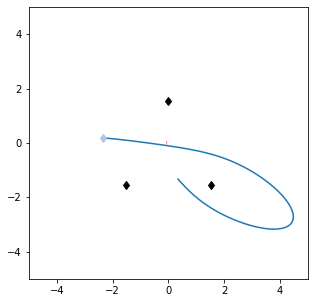

In [241]:
test_idx = np.random.randint(150)
x=torch.Tensor(simulation_train[test_idx])
x=torch.unsqueeze(x, 0)
y_pred = model_3_22(x, simulation_continued_train[test_idx].shape[1])

new_y_pred = y_pred.to(device='cpu').detach().numpy()
    
plot_example(simulation_train[test_idx], np.array(new_y_pred))

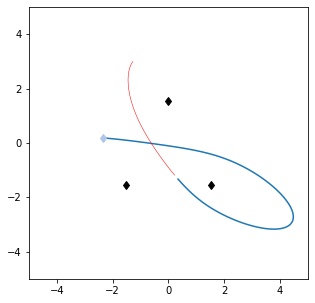

In [242]:
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])

In [174]:
from tqdm import tqdm

train_loss_graph, val_loss_graph = list(), list()

def avg_cont_err(model, dl, loss_fn=torch.nn.L1Loss(reduction='sum')):
    loss = 0
    n_samples = 0
    for x, y in dl:
        for inx, y_i in enumerate(y[0]):
            y_pred = model(x, inx)
            y_i = y_i.view(-1)
            loss += loss_fn(y_pred, y_i)
        n_samples += y.shape[1]
    return loss / n_samples


def fit_3_2(model, train_dl, valid_dl, n_epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
    loss_func = torch.nn.L1Loss()
    loss_func = loss_func.to(device)

    for i in range(epochs):
        print(f'Begin epoch {i + 1}/{n_epochs}')
        for x, y in tqdm(train_dl):
            for inx, y_i in enumerate(y[0]):
                y_pred = model(x, inx)
                y_i = torch.unsqueeze(y_i, 0)
                loss = loss_func(y_pred, y_i)
                loss.backward()
                optimizer.step()
                            
            optimizer.zero_grad()
        
        with torch.no_grad():
            train_err = avg_cont_err(model, train_dl)
            val_err = avg_cont_err(model, valid_dl)
            print(f'L1 train error: {train_err}')
            print(f'L1 validation error: {val_err}')
            train_loss_graph.append(train_err)
            val_loss_graph.append(val_err)


In [175]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

hidden_size = 30
n_layers = 5
model_3_2 = Model_3_2(hidden_size, n_layers, 1).to(device)
print(f'Model has {count_parameters(model_3_2)} parameters')
epochs = 10
fit_3_2(model_3_2, gpu_cont_train_dl, gpu_cont_valid_dl, epochs)

Model has 25442 parameters
Begin epoch 1/10


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:24<00:00,  6.09it/s]
C:\Users\Pim\anaconda3\envs\deeplearning\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


L1 train error: 3.6840591430664062
L1 validation error: 3.7910757064819336
Begin epoch 2/10


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:23<00:00,  6.45it/s]


L1 train error: 3.644887685775757
L1 validation error: 3.783282995223999
Begin epoch 3/10


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:23<00:00,  6.44it/s]


L1 train error: 3.4045379161834717
L1 validation error: 3.5461318492889404
Begin epoch 4/10


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:23<00:00,  6.46it/s]


L1 train error: 3.36108660697937
L1 validation error: 3.496793508529663
Begin epoch 5/10


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:23<00:00,  6.44it/s]


L1 train error: 3.2292494773864746
L1 validation error: 3.3684799671173096
Begin epoch 6/10


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:23<00:00,  6.47it/s]


L1 train error: 3.51680326461792
L1 validation error: 3.633303165435791
Begin epoch 7/10


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:23<00:00,  6.51it/s]


L1 train error: 4.044950485229492
L1 validation error: 4.1640849113464355
Begin epoch 8/10


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:22<00:00,  6.54it/s]


L1 train error: 3.5754809379577637
L1 validation error: 3.6634109020233154
Begin epoch 9/10


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:25<00:00,  5.89it/s]


L1 train error: 3.748877763748169
L1 validation error: 3.835726022720337
Begin epoch 10/10


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:26<00:00,  5.71it/s]


L1 train error: 3.3493378162384033
L1 validation error: 3.5238139629364014


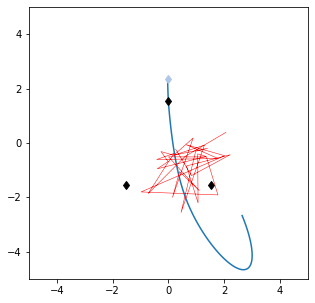

In [176]:
test_idx = np.random.randint(150)
x=torch.Tensor(simulation_train[test_idx])
x=torch.unsqueeze(x, 0)
y_pred = list()
for i in range(len(simulation_continued_train[test_idx])):
    y_pred.append(model_3_2(x, i))

new_y_pred = list()
for y_ii in y_pred:
    new_y_pred.append(y_ii[0].to(device='cpu').detach().numpy())
    
plot_example(simulation_train[test_idx], np.array(new_y_pred))

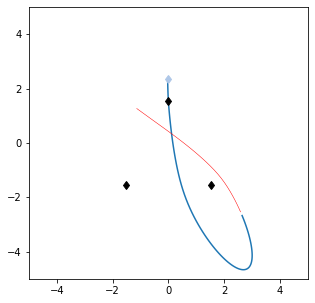

In [177]:
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])

## Model Training

In [18]:
#todo

## Evaluation

In [19]:
#todo